# The impact of coordinate-features on prediction models of air-traffic arrival time

In [1]:
from joblib import load
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from train_model.linear_model import LinearModel
from train_model.preprocessing import generate_aux_columns, seconds_till_arrival
from train_model.sequential_model import SequentialModel

## Describing the Data
The data consists of 4 months of Lufthansa-Flights from all over the world arriving at Frankfurt Airport. The months are January trhough April 2023. To thin out the autocorrelated data and for testing purposes every 1 thousandth row was extracted.

In [2]:
data_path = ".." + os.sep + "data" + os.sep + "test_data.csv"
scaler_path = ".." + os.sep + "trained_models" + os.sep + "std_scaler_reg_new.bin"
df_test = pd.read_csv(data_path, parse_dates=["arrival_time", "timestamp"])
print(df_test.shape)
df_test.head()

(65282, 10)


,distance,altitude,geoaltitude,arrival_time,timestamp,vertical_rate,groundspeed,track,latitude,longitude
0,1252.750377,450.0,1000.0,2023-02-01 19:27:29+00:00,2023-02-01 17:23:37+00:00,2496.0,149.0,240.159546,39.548035,2.711772
1,1104.308928,33375.0,33875.0,2023-02-01 19:27:29+00:00,2023-02-01 17:40:16+00:00,1856.0,445.0,23.570416,40.623065,4.018499
2,883.380798,36025.0,36300.0,2023-02-01 19:27:29+00:00,2023-02-01 17:56:55+00:00,0.0,421.0,28.208581,42.454971,5.102775
3,672.802116,36025.0,36125.0,2023-02-01 19:27:29+00:00,2023-02-01 18:13:35+00:00,64.0,412.0,27.311534,44.175476,6.336620
4,469.398678,36050.0,35850.0,2023-02-01 19:27:29+00:00,2023-02-01 18:30:15+00:00,64.0,401.0,24.585717,45.905731,7.253053


           distance      altitude   geoaltitude  vertical_rate   groundspeed  \
count  65282.000000  65282.000000  65282.000000   65282.000000  65282.000000   
mean    1116.312358  26663.877485  26578.315615     -52.766030    397.711391   
std     1782.749988  12440.205958  12241.776167    1068.192918    105.397279   
min        0.279951   -475.000000    -50.000000   -5440.000000      0.000000   
25%      162.987594  16275.000000  16375.000000    -576.000000    358.000000   
50%      517.635068  33350.000000  33075.000000       0.000000    422.000000   
75%     1112.815889  36050.000000  36275.000000       0.000000    461.000000   
max    11498.943585  92700.000000  81175.000000    6080.000000   1445.000000   

              track      latitude     longitude       holiday       sec_sin  \
count  65282.000000  65282.000000  65282.000000  65282.000000  65282.000000   
mean     185.420707     47.489172      5.072995      0.023146      0.161067   
std      112.091195      7.192503     25.8

C:\Users\dario\AppData\Local\Temp\ipykernel_15924\2486477975.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = X_descriptive[cols_to_correlate].corr()


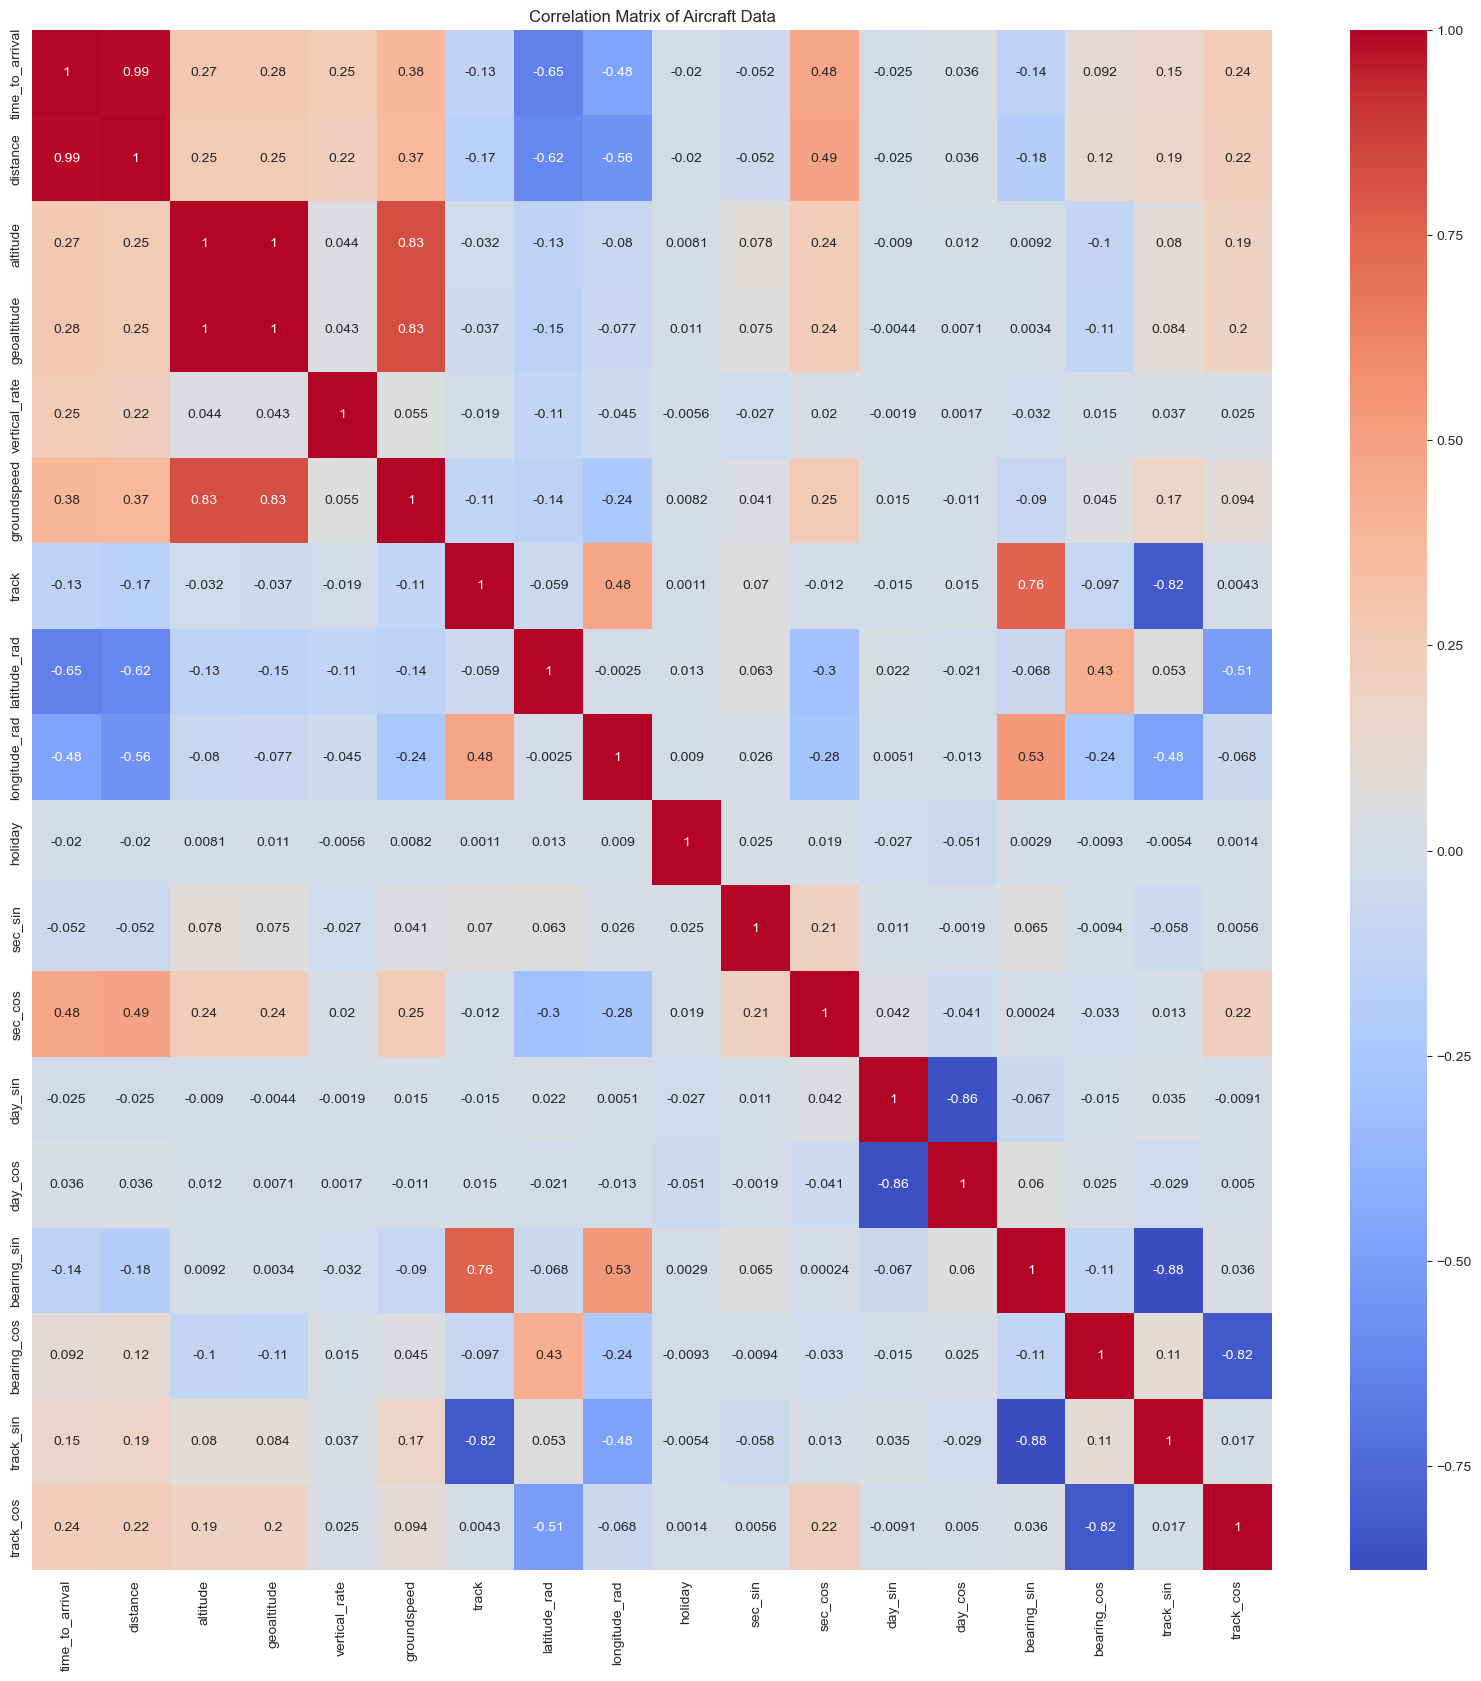

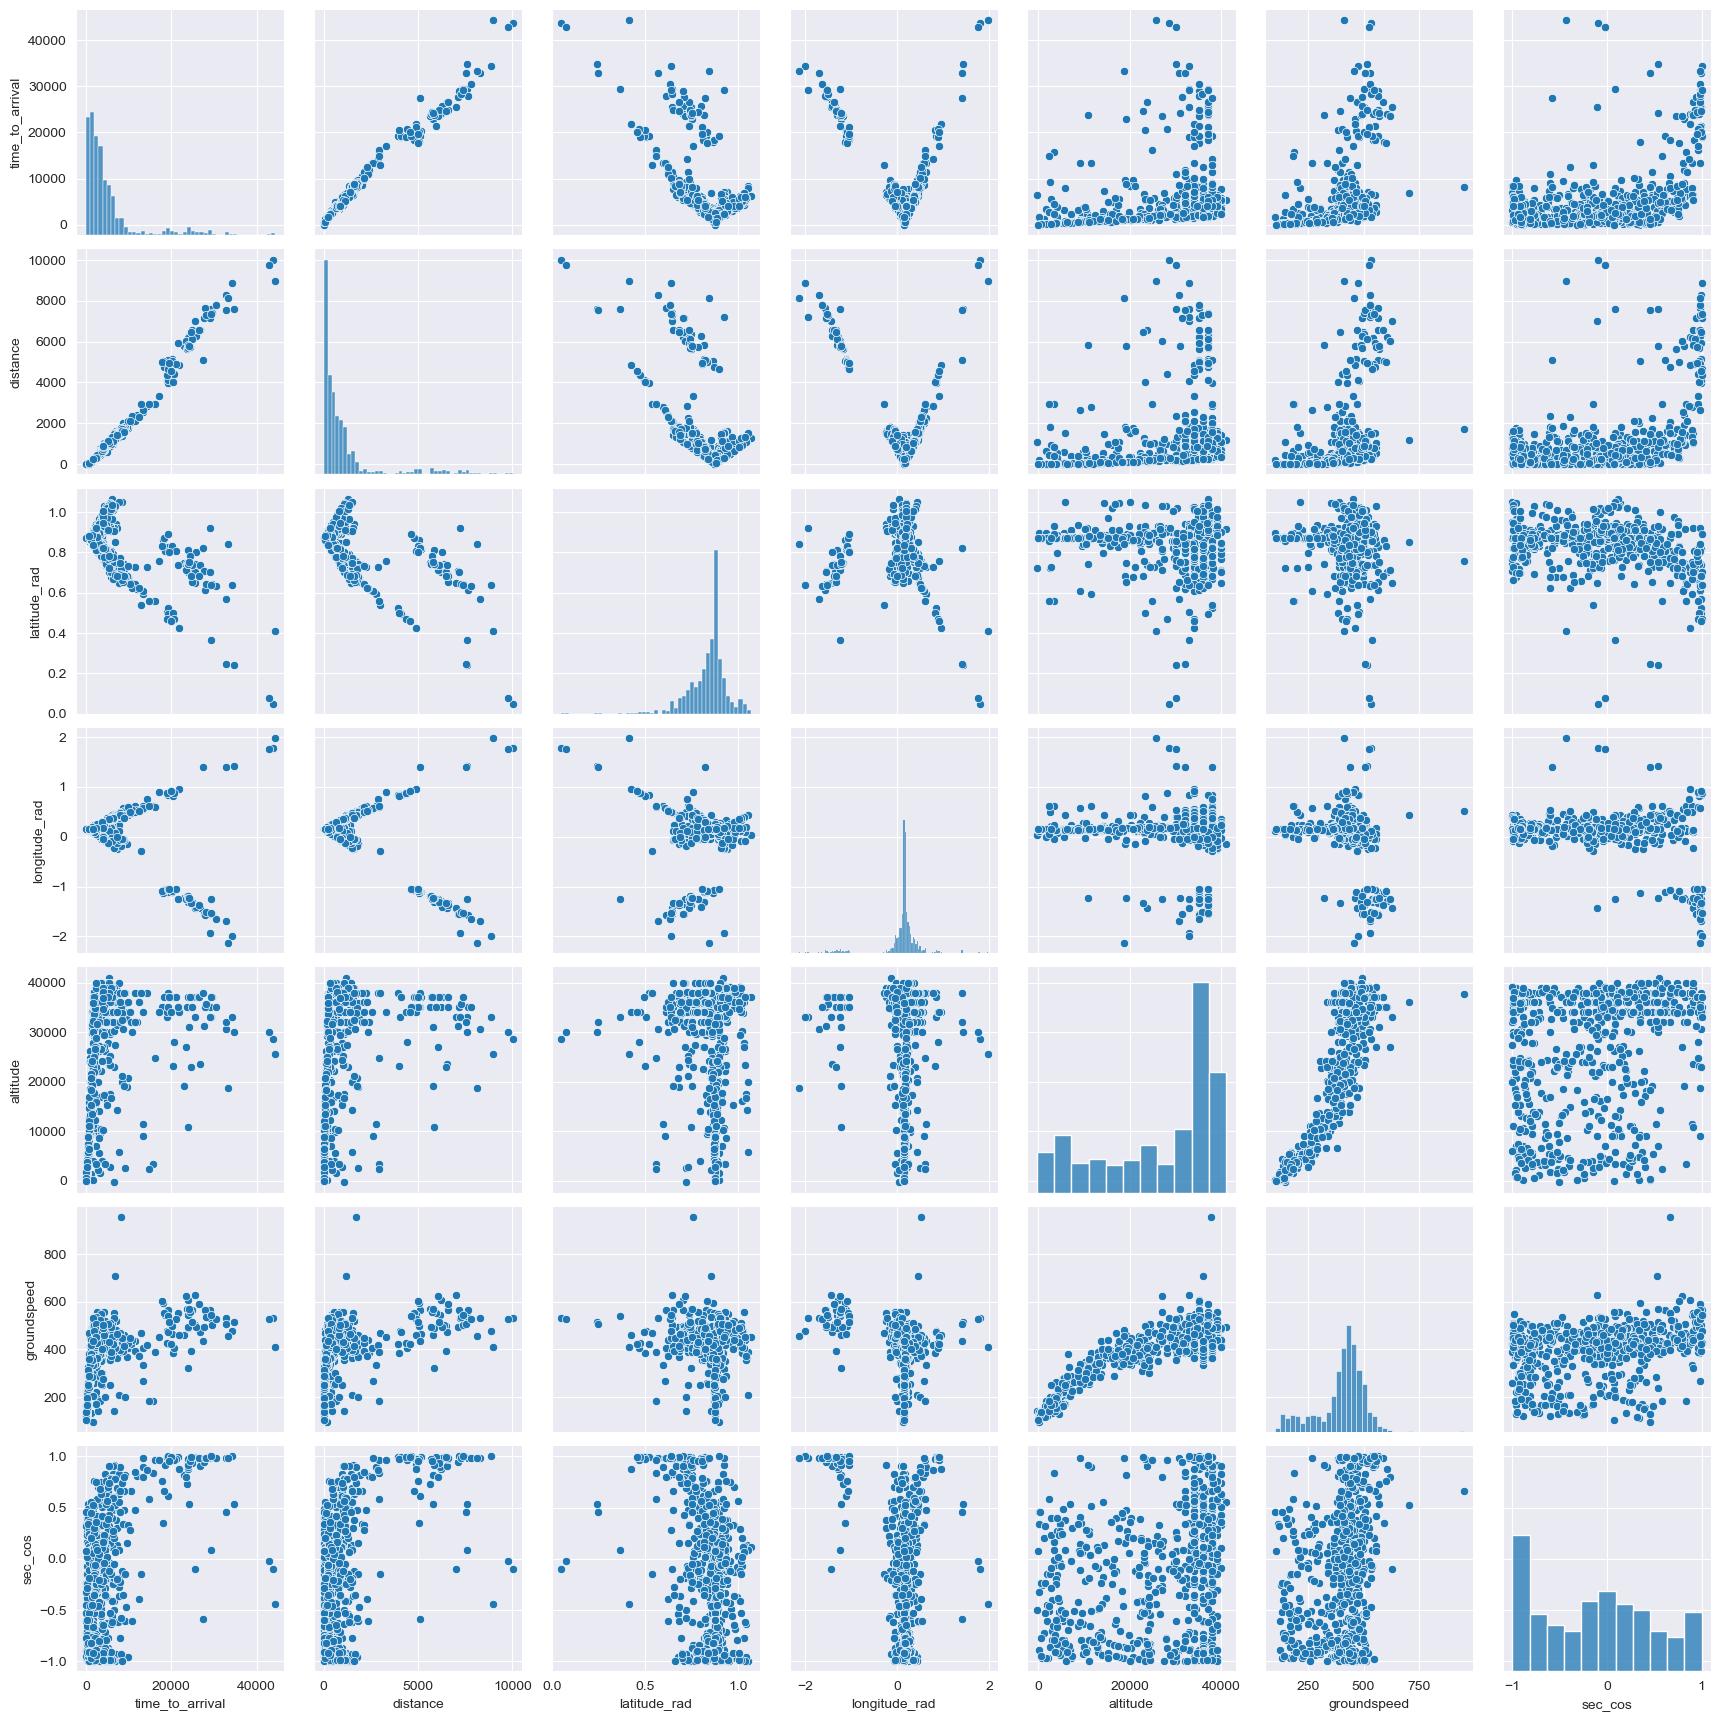

In [3]:
# Assuming 'X' and 'y' are pandas DataFrame and Series respectively
X = generate_aux_columns(df_test)
y = seconds_till_arrival(df_test)
X_descriptive = X.copy(deep=True)
X_descriptive['time_to_arrival'] = y  # Add target column to the main dataset for correlation calculations and pairplot

# Generate descriptive statistics
print(X_descriptive.describe())
cols_to_correlate = ['time_to_arrival', 'distance', 'altitude', 'geoaltitude', 'arrival_time', 'timestamp',
       'vertical_rate', 'groundspeed', 'track', 'latitude_rad', 'longitude_rad', 'holiday', 'sec_sin', 'sec_cos', 'day_sin', 'day_cos', 'bearing_sin', 'bearing_cos', 'track_sin', 'track_cos']
# Correlation matrix
correlation_matrix = X_descriptive[cols_to_correlate].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Aircraft Data')
plt.show()

# Pairplot for selected features to understand the relationship
selected_features = ['time_to_arrival','distance', 'latitude_rad','longitude_rad','altitude', 'groundspeed', 'sec_cos']
sns.pairplot(X_descriptive[selected_features].sample(frac=0.01))
plt.show()

There is an almost perfect correlation of distance and time to arrival. It's difficult to see the actual importance of other features, due to correlation with distance. We therefore create a partial correlation plot, partialing out distance.

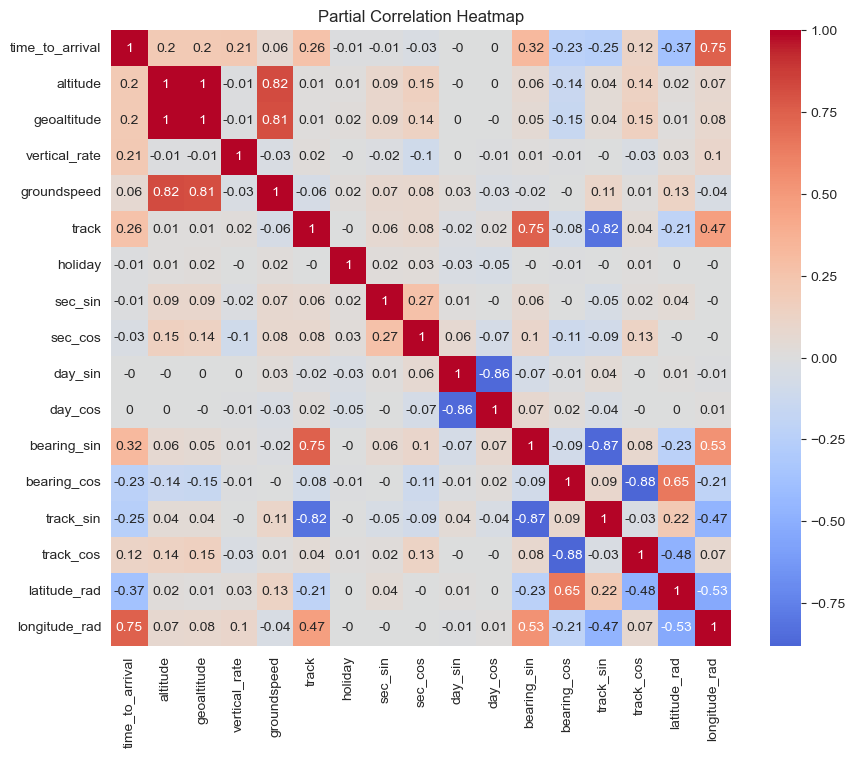

In [4]:
from pingouin import partial_corr

# assuming that df is your DataFrame and that columns is a list with the names of the columns you are interested in

columns =  ['time_to_arrival', 'altitude', 'geoaltitude','vertical_rate', 'groundspeed', 'track',
       'holiday', 'sec_sin', 'sec_cos', 'day_sin', 'day_cos', 'bearing_sin',
       'bearing_cos', 'track_sin', 'track_cos', "latitude_rad", "longitude_rad"]  # replace this with your actual column names
df = X_descriptive # replace this with your actual DataFrame
df["latitude_rad"]=np.radians(df.latitude)
df["longitude_rad"]=np.radians(df.longitude)
partial_corr_data = pd.DataFrame()

# calculate the partial correlation for each pair of columns
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            # calculate the partial correlation
            partial_corr_value = partial_corr(data=df, x=col1, y=col2, covar='distance').round(2)
            partial_corr_data.loc[col1, col2] = partial_corr_value['r'][0]
        else:
            # the correlation of a variable with itself is 1
            partial_corr_data.loc[col1, col2] = 1

# create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(partial_corr_data, annot=True, cmap='coolwarm', center=0)
plt.title('Partial Correlation Heatmap')
plt.show()


In [5]:
df

,distance,altitude,geoaltitude,arrival_time,timestamp,vertical_rate,groundspeed,track,latitude,longitude,...,latitude_rad,longitude_rad,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,time_to_arrival
0,1252.750377,450.0,1000.0,2023-02-01 19:27:29+00:00,2023-02-01 17:23:37+00:00,2496.0,149.0,240.159546,39.548035,2.711772,...,0.690243,0.047329,0,0,1,0,0,0,0,7432.0
1,1104.308928,33375.0,33875.0,2023-02-01 19:27:29+00:00,2023-02-01 17:40:16+00:00,1856.0,445.0,23.570416,40.623065,4.018499,...,0.709006,0.070136,0,0,1,0,0,0,0,6433.0
2,883.380798,36025.0,36300.0,2023-02-01 19:27:29+00:00,2023-02-01 17:56:55+00:00,0.0,421.0,28.208581,42.454971,5.102775,...,0.740979,0.089060,0,0,1,0,0,0,0,5434.0
3,672.802116,36025.0,36125.0,2023-02-01 19:27:29+00:00,2023-02-01 18:13:35+00:00,64.0,412.0,27.311534,44.175476,6.336620,...,0.771008,0.110595,0,0,1,0,0,0,0,4434.0
4,469.398678,36050.0,35850.0,2023-02-01 19:27:29+00:00,2023-02-01 18:30:15+00:00,64.0,401.0,24.585717,45.905731,7.253053,...,0.801206,0.126590,0,0,1,0,0,0,0,3434.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65277,853.991292,35000.0,34375.0,2023-04-30 09:33:50+00:00,2023-04-30 08:15:51+00:00,0.0,461.0,180.000000,57.660067,10.231550,...,1.006358,0.178574,0,0,0,0,0,0,1,4679.0
65278,624.181568,35025.0,34675.0,2023-04-30 09:33:50+00:00,2023-04-30 08:32:33+00:00,0.0,452.0,180.126760,55.564379,10.227242,...,0.969781,0.178499,0,0,0,0,0,0,1,3677.0
65279,400.395397,34975.0,34825.0,2023-04-30 09:33:50+00:00,2023-04-30 08:49:13+00:00,64.0,447.0,180.000000,53.491745,10.223485,...,0.933607,0.178433,0,0,0,0,0,0,1,2677.0
65280,186.564968,29075.0,29350.0,2023-04-30 09:33:50+00:00,2023-04-30 09:05:53+00:00,-1920.0,429.0,189.922960,51.501858,9.864120,...,0.898877,0.172161,0,0,0,0,0,0,1,1677.0


We can see that after partialling out distance, the coordinate feature still have very high corrletions with time to arrival. .

## Performance of Machine-Learning Models to predict arrival-time
### Polynomial Regression
To have baselines for more complex models, we first fit polynomial Regressions. The models were fit on training-data from all over 2022. The degree of polynomials was computed by increasing the degree until the mean-absolute error on the test data did not improve anymore. Two models were fit: One model with, and one without and one with the corrdinate features bearing-sin, bearing-cos, and latitude-rad, and longitude-rad.
They appear to be important features. Bearing is the angle of the north-pole streching to Frankfurt airport and the current coordinate

In [10]:
# load scaler and model
scaler = load(scaler_path)
features_simple =  ['distance', 'altitude', 'vertical_rate', 'groundspeed', 'holiday', 'sec_sin', 'sec_cos', 'day_sin',
                    'day_cos',  'track_sin', 'track_cos', 'weekday_1','weekday_2', 'weekday_3', 'weekday_4',
                    'weekday_5', 'weekday_6']
cols_to_scale = ["distance", "altitude", "geoaltitude", "vertical_rate", "groundspeed"]

model_file_simple = ".." + os.sep + "trained_models" + os.sep + "regression_no_coord_deg_7.sav"
linear_model_no_coord =  LinearModel(cols=features_simple, pol_degree=7, scaler=scaler)
linear_model_no_coord.model = load(model_file_simple)

In [11]:
X_test_processed = linear_model_no_coord.preprocess(X, cols_to_scale)
linear_model_no_coord.evaluate(X_test_processed, y)

(349.4994756069891, 0.9904360991640219)

The model without coordinate-features explains 99% of the variance of seconds till arrival and has a Mean Absolute Error of 349 seconds or 5:49 minutes

In [12]:
features_with_coord =['distance', 'altitude', 'vertical_rate', 'groundspeed', 'holiday', 'sec_sin', 'sec_cos', 'day_sin',
                    'day_cos', 'bearing_sin', 'bearing_cos', 'track_sin', 'track_cos', 'latitude_rad', 'longitude_rad',
                    'weekday_1','weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
cols_to_scale = ["distance", "altitude", "geoaltitude", "vertical_rate", "groundspeed"]

model_file_coord = ".." + os.sep + "trained_models" + os.sep + "regression_with_coord_deg_6.sav"
linear_model_with_coord =  LinearModel(cols=features_with_coord, pol_degree=6, scaler=scaler)
linear_model_with_coord.model = load(model_file_coord)

In [13]:
X_test_processed_coord = linear_model_with_coord.preprocess(X, cols_to_scale)
linear_model_with_coord.evaluate(X_test_processed_coord, y)

(282.47307261025884, 0.9959612650602642)

The model with coordinate-features explains 99.6% of the variance of seconds till arrival and has a Mean Absolute Error of 282 seconds or 4:42 minutes. Every more complex model must beat this.

## Deep Learning
### Deep Learning Model without coordinate features

In [6]:
model_path = ".." + os.sep + "trained_models" + os.sep + "dl_model_0602_no_coord"
X = generate_aux_columns(df_test)
y = seconds_till_arrival(df_test)
X = X.drop(columns=["arrival_time", "timestamp", "track", "latitude", "longitude", "bearing_sin", "bearing_cos", "latitude_rad", "longitude_rad"])
#model_normal = SequentialModel(build_new=False, model_path=model_path, cols_to_scale=[0,1,2,3,4], scaler=scaler)
#model_normal.model.summary()
#model_normal.evaluate(X, y)

In [8]:
X["time_to_arriva"]=y
X

,distance,altitude,geoaltitude,vertical_rate,groundspeed,holiday,sec_sin,sec_cos,day_sin,day_cos,track_sin,track_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,time_to_arriva
0,1252.750377,450.0,1000.0,2496.0,149.0,0,-0.987425,-0.158086,0.523416,0.852078,-8.674143e-01,-0.497587,0,0,1,0,0,0,0,7432.0
1,1104.308928,33375.0,33875.0,1856.0,445.0,0,-0.996295,-0.085997,0.523416,0.852078,3.998758e-01,0.916569,0,0,1,0,0,0,0,6433.0
2,883.380798,36025.0,36300.0,0.0,421.0,0,-0.999910,-0.013453,0.523416,0.852078,4.726828e-01,0.881233,0,0,1,0,0,0,0,5434.0
3,672.802116,36025.0,36125.0,64.0,412.0,0,-0.998244,0.059234,0.523416,0.852078,4.588284e-01,0.888525,0,0,1,0,0,0,0,4434.0
4,469.398678,36050.0,35850.0,64.0,401.0,0,-0.991302,0.131608,0.523416,0.852078,4.160541e-01,0.909340,0,0,1,0,0,0,0,3434.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65277,853.991292,35000.0,34375.0,0.0,461.0,0,0.829403,-0.558650,0.880012,-0.474951,1.224647e-16,-1.000000,0,0,0,0,0,0,1,4679.0
65278,624.181568,35025.0,34675.0,0.0,452.0,0,0.786531,-0.617551,0.880012,-0.474951,-2.212384e-03,-0.999998,0,0,0,0,0,0,1,3677.0
65279,400.395397,34975.0,34825.0,64.0,447.0,0,0.739582,-0.673066,0.880012,-0.474951,1.224647e-16,-1.000000,0,0,0,0,0,0,1,2677.0
65280,186.564968,29075.0,29350.0,-1920.0,429.0,0,0.688724,-0.725024,0.880012,-0.474951,-1.723238e-01,-0.985040,0,0,0,0,0,0,1,1677.0


In [9]:
X.to_csv("flights_data.csv", index=False)

The deep-learning model without coordinate features is already beating the linear polynomial regression by 26 seconds.
### Deep Learning Model with coordinate features

In [16]:
model_path = ".." + os.sep + "trained_models" + os.sep + "dl_model_0601_coord_rad"
X = generate_aux_columns(df_test)
y = seconds_till_arrival(df_test)
X = X.drop(columns=["arrival_time", "timestamp", "track", "latitude", "longitude"])
model_normal = SequentialModel(build_new=False, model_path=model_path, cols_to_scale=[0,1,2,3,4], scaler=scaler)
model_normal.model.summary()
model_normal.evaluate(X, y)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              24576     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1

235.14808654785156

Adding coordinate features improves the model by another 21 seconds.
### Exploring the relationship between distance and MAE

2041/2041 [==============================] - 4s 2ms/step
R² score: 0.34268490610425106


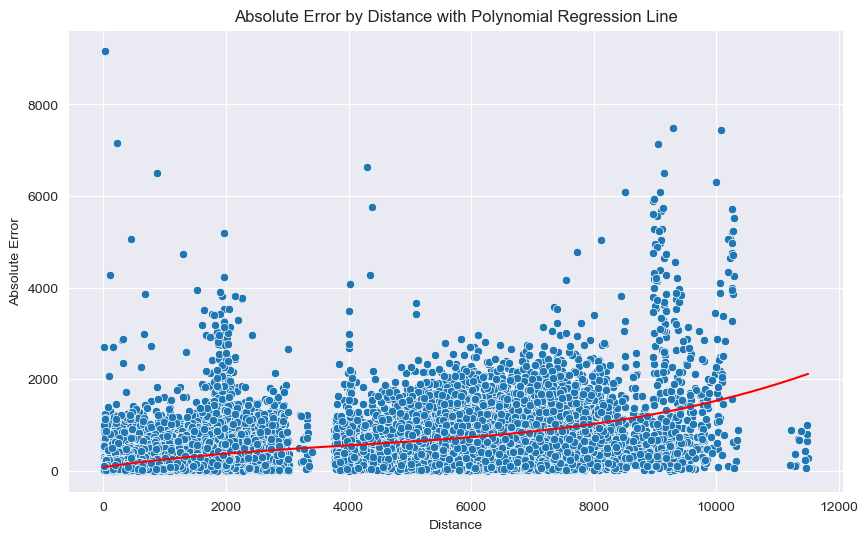

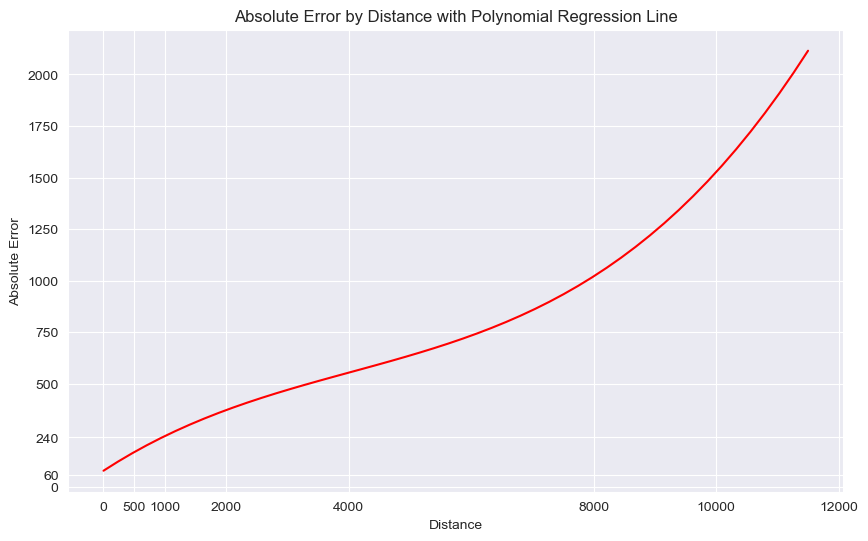

In [17]:
# Predicting the target variable 'y' with your model
y_pred = model_normal.predict(X)

# Reshape y_pred to match the shape of y
y_pred = y_pred.reshape(-1)

# Calculate absolute error
abs_error = abs(y - y_pred)

# Add absolute error to the DataFrame
X['abs_error'] = abs_error
df_test['abs_error'] = abs_error

# Define a pipeline to create a polynomial transformation of the 'distance' feature
# Then fit a linear regression model to these transformed features
X_dist = df_test['distance'].values.reshape(-1,1)
Y_err = X['abs_error'].values.reshape(-1,1)

degree = 3  # Start with 2, increase to see fit improvement
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X_dist, Y_err)

# Compute the R² of the regression
r2_score = polyreg.score(X_dist, Y_err)
print(f"R² score: {r2_score}")

# Predicting

y_pred_poly = polyreg.predict(np.expand_dims(np.linspace(X_dist.min(),X_dist.max()), axis=1))

# Plotting the polynomial regression line on top of the absolute error plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_test, x='distance', y='abs_error')
plt.plot(np.linspace(X_dist.min(),X_dist.max()), y_pred_poly, color='red')  # polynomial regression line
plt.title('Absolute Error by Distance with Polynomial Regression Line')
plt.xlabel('Distance')
plt.ylabel('Absolute Error')
plt.show()


# Plotting only data points before atlantic
plt.figure(figsize=(10,6))
#sns.scatterplot(data=df_test.loc[df_test.distance <= 3500], x='distance', y='abs_error')

plt.plot(np.linspace(X_dist.min(),X_dist.max()), y_pred_poly, color='red')
plt.title('Absolute Error by Distance with Polynomial Regression Line')
plt.xlabel('Distance')
plt.ylabel('Absolute Error')
plt.xticks([0, 500,1000, 2000, 4000, 8000, 10000, 12000])
plt.yticks([0, 60, 240,500, 750, 1000, 1250, 1500, 1750, 2000])
plt.show()
# Remove 'abs_error' from DataFrame
X = X.drop(columns=['abs_error'])
df_test = df_test.drop(columns = ['abs_error'])


1863/1863 [==============================] - 3s 2ms/step
mae 179.35151731322
R² score: 0.16410914208585103


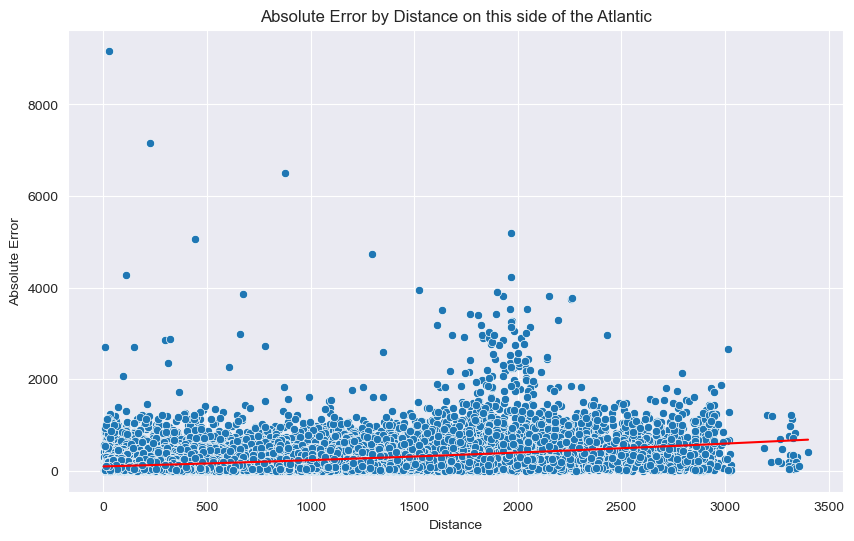

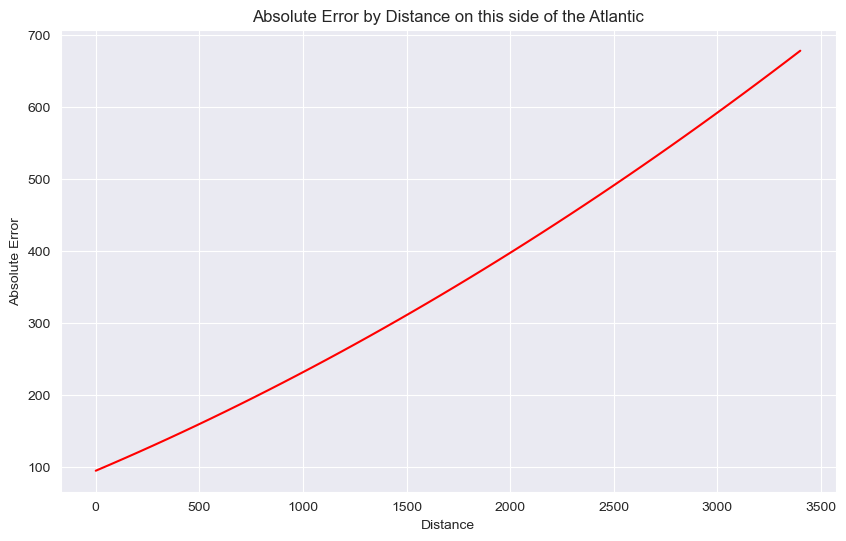

In [19]:
# Filter rows where df_test["distance"] is less than or equal to 10
max_distance = 3500
df_test_10 = df_test[df_test["distance"] <= max_distance]
X_10 = X[df_test["distance"] <= max_distance]
y_10 = y[df_test["distance"] <= max_distance]

# Predicting the target variable 'y' with your model
y_pred = model_normal.predict(X_10)

# Reshape y_pred to match the shape of y
y_pred = y_pred.reshape(-1)

# Calculate absolute error
abs_error = abs(y_10 - y_pred)
print("mae", abs_error.mean())
# Add absolute error to the DataFrame
X_10['abs_error'] = abs_error
df_test_10['abs_error'] = abs_error

# Define a pipeline to create a polynomial transformation of the 'distance' feature
# Then fit a linear regression model to these transformed features
X_dist_10 = df_test_10['distance'].values.reshape(-1,1)
Y_err_10 = X_10['abs_error'].values.reshape(-1,1)

degree = 2
polyreg_10 = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg_10.fit(X_dist_10, Y_err_10)

# Compute the R² of the regression
r2_score_10 = polyreg_10.score(X_dist_10, Y_err_10)
print(f"R² score: {r2_score_10}")

# Predicting
y_pred_poly_10 = polyreg_10.predict(np.expand_dims(np.linspace(X_dist_10.min(),X_dist_10.max()), axis=1))

# Plotting the polynomial regression line on top of the absolute error plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_test_10, x='distance', y='abs_error')
plt.plot(np.linspace(X_dist_10.min(),X_dist_10.max()), y_pred_poly_10, color='red')  # polynomial regression line
plt.title('Absolute Error by Distance on this side of the Atlantic')
plt.xlabel('Distance')
plt.ylabel('Absolute Error')
plt.ylim()
plt.show()

# Plotting the polynomial regression line on top of the absolute error plot
plt.figure(figsize=(10,6))
plt.plot(np.linspace(X_dist_10.min(),X_dist_10.max()), y_pred_poly_10, color='red')  # polynomial regression line
plt.title('Absolute Error by Distance on this side of the Atlantic')
plt.xlabel('Distance')
plt.ylabel('Absolute Error')
plt.ylim()
plt.show()

# Remove 'abs_error' from DataFrame
X_10 = X_10.drop(columns=['abs_error'])


We see that the error for planes after the traversed the Atlantic sufficiently enough to be able to send out signals decreases by almost one minute and is at 2:59 minutes. Let's explore the error of really close aircrafts within 100 miles of Frankfurt.

398/398 [==============================] - 1s 2ms/step
mae 70.90440214593228
R² score: 0.06965180316311848


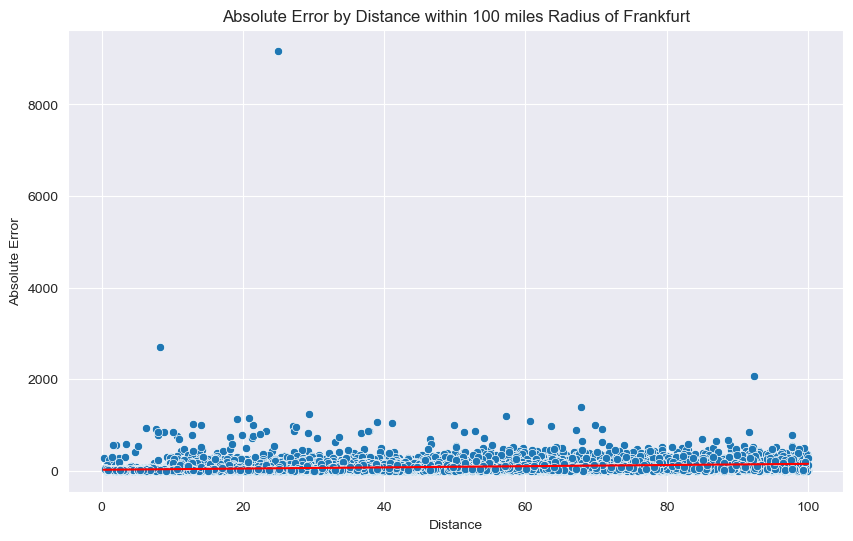

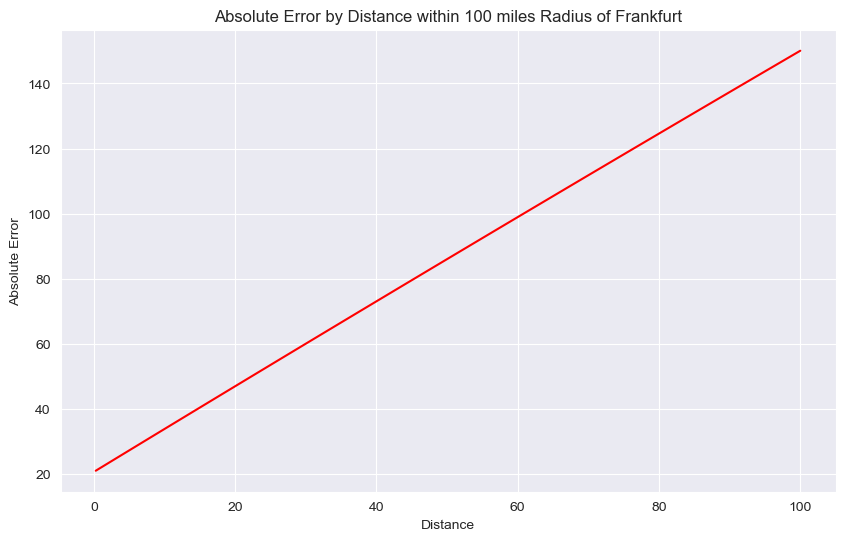

In [20]:
# Filter rows where df_test["distance"] is less than or equal to 100
max_distance = 100
df_test_10 = df_test[df_test["distance"] <= max_distance]
X_10 = X[df_test["distance"] <= max_distance]
y_10 = y[df_test["distance"] <= max_distance]

# Predicting the target variable 'y' with your model
y_pred = model_normal.predict(X_10)

# Reshape y_pred to match the shape of y
y_pred = y_pred.reshape(-1)

# Calculate absolute error
abs_error = abs(y_10 - y_pred)
print("mae", abs_error.mean())
# Add absolute error to the DataFrame
X_10['abs_error'] = abs_error
df_test_10['abs_error'] = abs_error

# Define a pipeline to create a polynomial transformation of the 'distance' feature
# Then fit a linear regression model to these transformed features
X_dist_10 = df_test_10['distance'].values.reshape(-1,1)
Y_err_10 = X_10['abs_error'].values.reshape(-1,1)

degree = 2
polyreg_10 = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg_10.fit(X_dist_10, Y_err_10)

# Compute the R² of the regression
r2_score_10 = polyreg_10.score(X_dist_10, Y_err_10)
print(f"R² score: {r2_score_10}")

# Predicting
y_pred_poly_10 = polyreg_10.predict(np.expand_dims(np.linspace(X_dist_10.min(),X_dist_10.max()), axis=1))

# Plotting the polynomial regression line on top of the absolute error plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_test_10, x='distance', y='abs_error')
plt.plot(np.linspace(X_dist_10.min(),X_dist_10.max()), y_pred_poly_10, color='red')  # polynomial regression line
plt.title('Absolute Error by Distance within 100 miles Radius of Frankfurt')
plt.xlabel('Distance')
plt.ylabel('Absolute Error')
plt.ylim()
plt.show()

# Plotting the polynomial regression line on top of the absolute error plot
plt.figure(figsize=(10,6))
plt.plot(np.linspace(X_dist_10.min(),X_dist_10.max()), y_pred_poly_10, color='red')  # polynomial regression line
plt.title('Absolute Error by Distance within 100 miles Radius of Frankfurt')
plt.xlabel('Distance')
plt.ylabel('Absolute Error')
plt.ylim()
plt.show()

# Remove 'abs_error' from DataFrame
X_10 = X_10.drop(columns=['abs_error'])



The relationship between distance and error becomes really small when distance is small. Distance only explains 7% of variance. The error is 70 seconds.
### Predicting Time to arrival/ distance
As the optimizer tries to minimize the mean absolute error, larger distances which naturally are more difficult to predict precisely have larger errors and thus influence the training to a larger degree. However an error of 60 seconds is very different in quality of prediction for flights that are 1000s of miles away than those that are very near. To take this into account we minimize the seconds divided by distance in the next model.

In [24]:
model_path_timedist = ".." + os.sep + "trained_models" + os.sep + "dl_model_timedistance"
X = generate_aux_columns(df_test)
y = seconds_till_arrival(df_test)
X = X.drop(columns=["arrival_time", "timestamp", "track", "latitude", "longitude", "latitude_rad", "longitude_rad"])
def postprocess_function(X, y_pred):
    X_dist = np.array(X.iloc[:, 0]).reshape(-1)
    y_low_dim = np.array(y_pred).reshape(-1)
    return y_low_dim*X_dist

model_timedist = SequentialModel(build_new=False, model_path=model_path_timedist, cols_to_scale=[0,1,2,3,4], scaler=scaler, postprocess_output_function=postprocess_function)
model_timedist.model.summary()

model_timedist.evaluate(X, y, postprocess_output=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              22528     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1

232.3868177761653

2041/2041 [==============================] - 3s 2ms/step
R² score: 0.36006844294755824


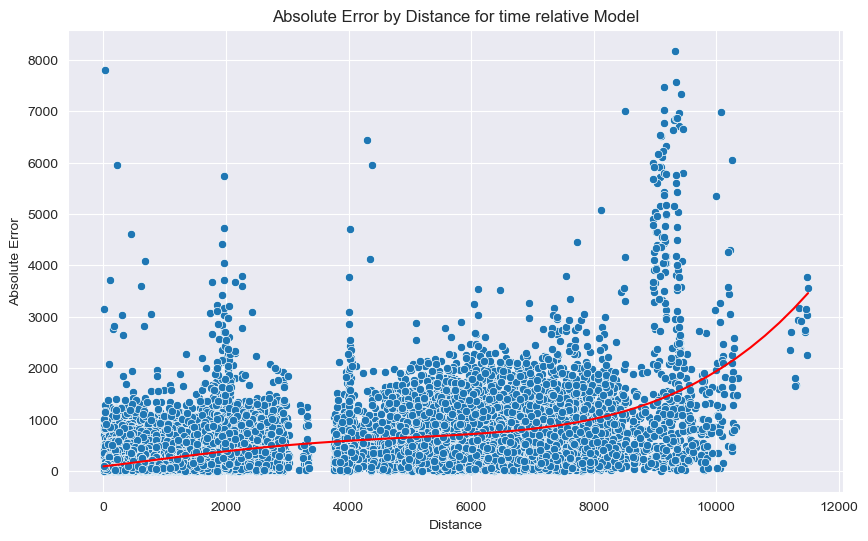

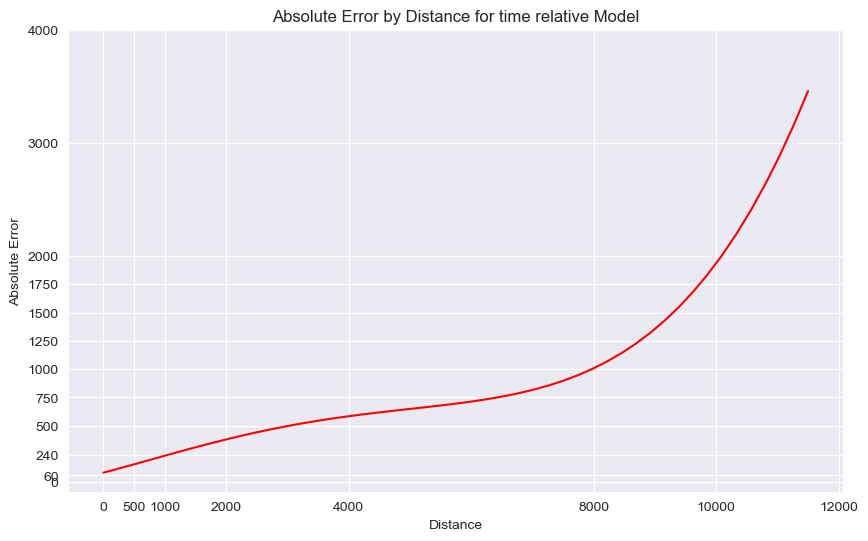

In [27]:
# Predicting the target variable 'y' with your model
y_pred = model_timedist.predict(X, postprocess_output=True)

# Reshape y_pred to match the shape of y
y_pred = y_pred.reshape(-1)

# Calculate absolute error
abs_error = abs(y - y_pred)

# Add absolute error to the DataFrame
X['abs_error'] = abs_error
df_test['abs_error'] = abs_error

# Define a pipeline to create a polynomial transformation of the 'distance' feature
# Then fit a linear regression model to these transformed features
X_dist = df_test['distance'].values.reshape(-1,1)
Y_err = X['abs_error'].values.reshape(-1,1)

degree = 4  # Start with 2, increase to see fit improvement
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X_dist, Y_err)

# Compute the R² of the regression
r2_score = polyreg.score(X_dist, Y_err)
print(f"R² score: {r2_score}")

# Predicting

y_pred_poly = polyreg.predict(np.expand_dims(np.linspace(X_dist.min(),X_dist.max()), axis=1))

# Plotting the polynomial regression line on top of the absolute error plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_test, x='distance', y='abs_error')
plt.plot(np.linspace(X_dist.min(),X_dist.max()), y_pred_poly, color='red')  # polynomial regression line
plt.title('Absolute Error by Distance for time relative Model')
plt.xlabel('Distance')
plt.ylabel('Absolute Error')
plt.show()


# Plotting only data points before atlantic
plt.figure(figsize=(10,6))
#sns.scatterplot(data=df_test.loc[df_test.distance <= 3500], x='distance', y='abs_error')

plt.plot(np.linspace(X_dist.min(),X_dist.max()), y_pred_poly, color='red')
plt.title('Absolute Error by Distance for time relative Model')
plt.xlabel('Distance')
plt.ylabel('Absolute Error')
plt.xticks([0, 500,1000, 2000, 4000, 8000, 10000, 12000])
plt.yticks([0, 60, 240,500, 750, 1000, 1250, 1500, 1750, 2000, 3000, 4000])
plt.show()
# Remove 'abs_error' from DataFrame
X = X.drop(columns=['abs_error'])
df_test = df_test.drop(columns = ['abs_error'])


398/398 [==============================] - 1s 2ms/step
mae 62.33909233467505
R² score: 0.06741065336599861


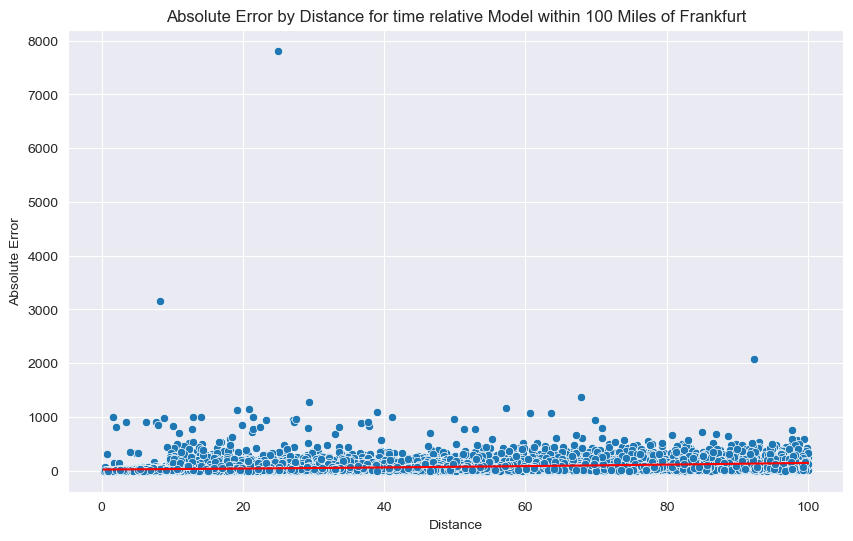

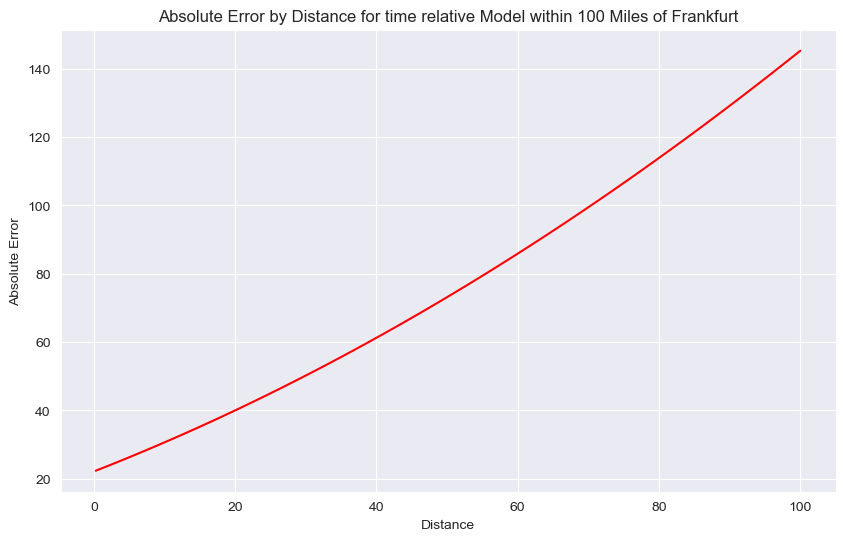

In [28]:
# Filter rows where df_test["distance"] is less than or equal to 10
max_distance = 100
df_test_10 = df_test[df_test["distance"] <= max_distance]
X_10 = X[df_test["distance"] <= max_distance]
y_10 = y[df_test["distance"] <= max_distance]

# Predicting the target variable 'y' with your model
y_pred = model_timedist.predict(X_10, postprocess_output=True)

# Reshape y_pred to match the shape of y
y_pred = y_pred.reshape(-1)

# Calculate absolute error
abs_error = abs(y_10 - y_pred)
print("mae", abs_error.mean())
# Add absolute error to the DataFrame
X_10['abs_error'] = abs_error
df_test_10['abs_error'] = abs_error

# Define a pipeline to create a polynomial transformation of the 'distance' feature
# Then fit a linear regression model to these transformed features
X_dist_10 = df_test_10['distance'].values.reshape(-1,1)
Y_err_10 = X_10['abs_error'].values.reshape(-1,1)

degree = 2
polyreg_10 = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg_10.fit(X_dist_10, Y_err_10)

# Compute the R² of the regression
r2_score_10 = polyreg_10.score(X_dist_10, Y_err_10)
print(f"R² score: {r2_score_10}")

# Predicting
y_pred_poly_10 = polyreg_10.predict(np.expand_dims(np.linspace(X_dist_10.min(),X_dist_10.max()), axis=1))

# Plotting the polynomial regression line on top of the absolute error plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_test_10, x='distance', y='abs_error')
plt.plot(np.linspace(X_dist_10.min(),X_dist_10.max()), y_pred_poly_10, color='red')  # polynomial regression line
plt.title('Absolute Error by Distance for time relative Model within 100 Miles of Frankfurt')
plt.xlabel('Distance')
plt.ylabel('Absolute Error')
plt.ylim()
plt.show()

# Plotting the polynomial regression line on top of the absolute error plot
plt.figure(figsize=(10,6))
plt.plot(np.linspace(X_dist_10.min(),X_dist_10.max()), y_pred_poly_10, color='red')  # polynomial regression line
plt.title('Absolute Error by Distance for time relative Model within 100 Miles of Frankfurt')
plt.xlabel('Distance')
plt.ylabel('Absolute Error')
plt.ylim()
plt.show()

# Remove 'abs_error' from DataFrame
X_10 = X_10.drop(columns=['abs_error'])

## Conclusion
-   Most of the Variance of Time To Arrival is explained by the distance feature.
-   The optimization problem comes down to explaining the rest of the error.
-   The coordinate features contain iformation which is not caputred by distance.
-   Including simple coordinate features raduces the error of a deep learning model by 24 seconds on average
-   Transforming the target variable (by dividing by distance) both decreases the overall error a bit, and makes the error more proportional to the distance

## Next Steps
-  More complex feature engineering (H3)
-  I

In [14]:
np.cos(np.radians(0))

1.0